[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/leventemarak/DeepSea-DeapLearn-HomeWork/blob/main/DeepSeaHW.ipynb
)

# **Deep Learning Homework** - Group DeepSea
# Team Members
[Csáki Márton] ([R0OQD4])

[Marák Levente] ([K2DE0K])

[Ogleznyev Pável] ([GRKO04])

## Project Overview

This project focuses on the semantic segmentation of ships in satellite images using the Airbus Ship Detection Challenge dataset. The goal is to accurately locate ships and create segmentation masks, distinguishing them from the open sea, clouds, and coastline. We implemented a deep learning solution using a custom U-Net architecture.

## 1. Step


In [ ]:
import os
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')

DRIVE_BASE_DIR = "/content/drive/MyDrive/DeepLearn"
TRAIN_IMG_DIR = os.path.join(DRIVE_BASE_DIR, "train_v2")
CSV_PATH = os.path.join(DRIVE_BASE_DIR, "train_ship_segmentations_v2.csv")


# IMG_SIZE: This will be the model input size (crop size)
IMG_SIZE = (384, 384)

ORIG_SIZE = (768, 768)
# BATCH_SIZE: Number of samples processed before the model is updated
BATCH_SIZE = 16

Mounted at /content/drive


## 2. Step

In [ ]:
import os
import zipfile

# Define the path to the ZIP file located in Google Drive
ZIP_PATH = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection.zip"

# Define the local destination directory on the Colab instance (Local SSD)
LOCAL_DIR = "/content/local_data"

# Construct the expected path for the training images
# We will verify the exact structure after extraction
LOCAL_TRAIN_DIR = os.path.join(LOCAL_DIR, "train_v2")

# Extraction Logic
if not os.path.exists(LOCAL_TRAIN_DIR):
    print(f"Unzipping ZIP file to fast local SSD from: {ZIP_PATH}...")

    if not os.path.exists(ZIP_PATH):
        print(f"ERROR: Invalid ZIP path! Please check: {ZIP_PATH}")
    else:
        # Create the destination directory
        os.makedirs(LOCAL_DIR, exist_ok=True)

        # Unzip process
        print("Unzipping in progress... (this may take 1-2 minutes)")
        !unzip -q "$ZIP_PATH" -d "$LOCAL_DIR"

        print("DONE! Data is now on the local SSD.")
else:
    print("Data is already present locally. Skipping extraction.")

# Path Verification and Configuration
# Check where the files were extracted and update the global image directory path
if os.path.exists(LOCAL_TRAIN_DIR):
    TRAIN_IMG_DIR = LOCAL_TRAIN_DIR
    print(f"SUCCESS! New fast image path set: {TRAIN_IMG_DIR}")

elif os.path.exists(os.path.join(LOCAL_DIR, "airbus-ship-detection", "train_v2")):
    # Handle case where the ZIP contained an extra nested folder
    TRAIN_IMG_DIR = os.path.join(LOCAL_DIR, "airbus-ship-detection", "train_v2")
    print(f"SUCCESS! (Found nested folder) Path: {TRAIN_IMG_DIR}")

else:
    print("WARNING: Unzipping finished, but 'train_v2' folder was not found.")
    print(f"Check the contents of: {LOCAL_DIR}")
    print(os.listdir(LOCAL_DIR))
    # If images are directly in LOCAL_DIR, you may need to set TRAIN_IMG_DIR = LOCAL_DIR

Unzipping ZIP file to fast local SSD from: /content/drive/MyDrive/DeepLearn/airbus-ship-detection.zip...
Unzipping in progress... (this may take 1-2 minutes)
DONE! Data is now on the local SSD.
SUCCESS! New fast image path set: /content/local_data/train_v2


## 3. Step

In [ ]:
import os

# Update the path: There is an extra 'airbus-ship-detection' folder inside 'DeepLearn'
CSV_PATH = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection/train_ship_segmentations_v2.csv"

# Quick verification to check if the file actually exists
if os.path.exists(CSV_PATH):
    print(f"CSV file found at: {CSV_PATH}")
else:
    print(f"STILL NOT FOUND AT: {CSV_PATH}")

    # If the file is missing at the expected path, perform an automated search
    print("Searching within the DeepLearn directory...")
    base = "/content/drive/MyDrive/DeepLearn"

    for root, dirs, files in os.walk(base):
        if "train_ship_segmentations_v2.csv" in files:
            print(f"Found it! It is hiding here: {os.path.join(root, 'train_ship_segmentations_v2.csv')}")

CSV file found at: /content/drive/MyDrive/DeepLearn/airbus-ship-detection/train_ship_segmentations_v2.csv


## 4. Step

In [ ]:
import pandas as pd
import numpy as np

print("Loading metadata...")
df = pd.read_csv(CSV_PATH)

# Handle missing values (NaN -> NO_SHIP)
df['EncodedPixels'] = df['EncodedPixels'].fillna('NO_SHIP')

# Group by ImageId (one image can have multiple ships/rows)
metadata = df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Create 'has_ship' column for filtering
def check_has_ship(rle_list):
    if len(rle_list) == 1 and rle_list[0] == 'NO_SHIP':
        return 0
    return 1

metadata['has_ship'] = metadata['EncodedPixels'].apply(check_has_ship)

# If no ship, replace the RLE list with an empty list
metadata.loc[metadata['has_ship'] == 0, 'EncodedPixels'] = metadata.loc[metadata['has_ship'] == 0, 'ImageId'].apply(lambda x: [])

print(f"Total number of images: {len(metadata)}")

Loading metadata...
Total number of images: 192556


## 5. Step

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd # Ensuring pandas is imported for concat operations

print("Splitting and balancing data...")

# Initial split (80% Train, 20% Validation)
# We use stratify to maintain the same ratio of ships/no-ships in both sets initially
train_df_raw, val_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['has_ship']
)

# DATA BALANCING
# 1. Keep all images containing ships
train_ships = train_df_raw[train_df_raw['has_ship'] == 1]

# 2. Undersample empty images with a 1:3 ratio
# Previously we used 1:1, but 1:3 allows more background variety (clouds/coastlines)
# while keeping the dataset manageable.
train_empty = train_df_raw[train_df_raw['has_ship'] == 0].sample(
    min(len(train_ships) * 3, len(train_df_raw[train_df_raw['has_ship'] == 0])),
    random_state=42
)

# Concatenate the ship images with the sampled empty images and shuffle the result
train_df_balanced = pd.concat([train_ships, train_empty]).sample(frac=1, random_state=42).reset_index(drop=True)

# Output dataset statistics for verification
print(f"Original training size: {len(train_df_raw)}")
print(f"Balanced training size (used for training): {len(train_df_balanced)}")
print(f"Validation size (remains original): {len(val_df)}")

Splitting and balancing data...
Original training size: 154044
Balanced training size (used for training): 136180
Validation size (remains original): 38512


## 6. Step

In [ ]:
import cv2

def rle_to_mask(rle_list, shape=(768, 768)):
    """
    Decodes a list of Run-Length Encoded (RLE) strings into a binary mask.
    The output is a (H, W, 1) NumPy array.
    """
    # Initialize a flat array of zeros (background)
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for rle in rle_list:
        if rle == 'NO_SHIP' or rle == '':
            continue

        # Parse the string: pairs of (start_position, length)
        s = list(map(int, rle.split()))
        starts, lengths = s[0::2], s[1::2]
        starts = np.array(starts) - 1  # Adjust for 0-based indexing

        # Set the corresponding pixels to 1 (ship)
        for start, length in zip(starts, lengths):
            mask[start:start + length] = 1

    # Reshape to 2D and Transpose (T) because RLE is usually column-major
    mask = mask.reshape(shape).T

    # Expand dimensions to (768, 768, 1) to match Keras input requirements
    return mask[..., np.newaxis]


# --- NEW HELPER: SMART CROP STRATEGY ---
def get_smart_crop(img, mask, crop_size=384):
    """
    Intelligent cropping mechanism:
    - If a ship exists: Centers the crop around the ship (with random jitter).
    - If no ship: Takes a random crop from the background.
    """
    h, w = img.shape[:2]

    if mask.sum() > 0:
        # If there is a ship, find the coordinates of ship pixels
        rows, cols = np.where(mask[:,:,0] == 1)

        if len(rows) > 0:
            # Select a random pixel belonging to a ship as an anchor point
            idx = np.random.randint(len(rows))
            cy, cx = rows[idx], cols[idx]

            # Calculate the top-left corner of the crop
            # We add 'jitter' (random offset) so the ship isn't always perfectly centered.
            # This prevents the model from "cheating" by assuming ships are always in the middle.
            jitter_x = np.random.randint(-50, 50)
            jitter_y = np.random.randint(-50, 50)

            top = cy - crop_size // 2 + jitter_y
            left = cx - crop_size // 2 + jitter_x

            # Clamp coordinates to ensure we stay within image boundaries
            top = max(0, min(top, h - crop_size))
            left = max(0, min(left, w - crop_size))
        else:
            # Fallback if mask sum > 0 but indices are weird (rare edge case)
            top = np.random.randint(0, h - crop_size)
            left = np.random.randint(0, w - crop_size)
    else:
        # For empty images, crop randomly.
        # This is crucial for the model to learn different types of empty sea, clouds, and waves.
        top = np.random.randint(0, h - crop_size)
        left = np.random.randint(0, w - crop_size)

    # Perform the actual cropping
    img_crop = img[top:top+crop_size, left:left+crop_size]
    mask_crop = mask[top:top+crop_size, left:left+crop_size]

    return img_crop, mask_crop

## 7. Step

In [ ]:
def data_generator(df, mode='train'):
    """
    Yields (image, mask) pairs for the model.

    mode='train': Applies Smart Cropping and Data Augmentation (Rotation/Flipping).
    mode='eval':  Applies standard resizing (deterministic).
    """
    while True:
        # In training mode, shuffle the data order at the beginning of every epoch
        if mode == 'train':
            df = df.sample(frac=1).reset_index(drop=True)

        for _, row in df.iterrows():
            image_id = row['ImageId']
            rle_list = row['EncodedPixels']
            img_path = os.path.join(TRAIN_IMG_DIR, image_id)

            # 1. Load original 768x768 image
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # ORIGINAL SIZE

            # 2. Generate original 768x768 mask from RLE
            mask = rle_to_mask(rle_list, shape=ORIG_SIZE)

            # 3. Image Processing
            if mode == 'train':
                # --- A: SMART CROP (Crop instead of Resize) ---
                # This preserves the resolution of small ships
                img, mask = get_smart_crop(img, mask, crop_size=IMG_SIZE[0])

                # --- B: AUGMENTATION (Rotation/Flipping) ---
                # Improves generalization and helps the model learn orientation invariance

                # Horizontal Flip
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)

                # Vertical Flip
                if np.random.rand() > 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)

                # 90-degree Rotation (Random 0, 90, 180, 270 degrees)
                if np.random.rand() > 0.5:
                    k = np.random.randint(1, 4)
                    img = np.rot90(img, k)
                    mask = np.rot90(mask, k)

            else:
                # Validation mode: Must be deterministic.
                # We use standard resizing here to strictly evaluate performance on the full image context.
                img = cv2.resize(img, IMG_SIZE)
                mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)

                # Ensure mask has the correct channel dimension
                mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask

            # 4. Normalization
            # Convert pixel values from [0, 255] to [0.0, 1.0]
            img = img.astype(np.float32) / 255.0
            mask = mask.astype(np.float32)

            yield img, mask

## 8. Step

In [ ]:
import tensorflow as tf

print("Building TensorFlow pipelines...")

# Training Pipeline
# Uses the balanced dataset with Smart Cropping and Augmentation enabled.
train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df_balanced, mode='train'),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32), # Input Image
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)  # Target Mask
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Pipeline
# Uses the original (imbalanced) dataset to reflect real-world performance.
# Uses standard resizing without augmentation.
val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df, mode='eval'),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32), # Input Image
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)  # Target Mask
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets are ready for training.")

Building TensorFlow pipelines...
Datasets are ready for training.


## 9. Step

Visualizing a batch (inspecting crops and augmentations)...


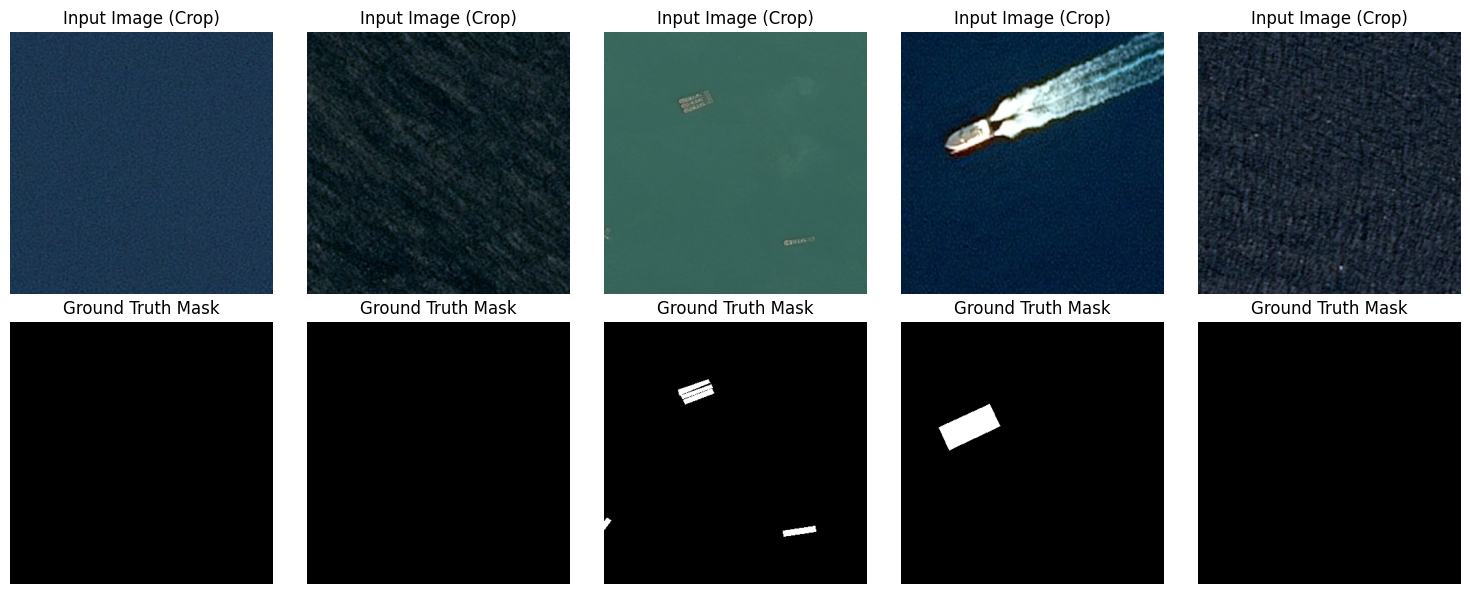

In [ ]:
import matplotlib.pyplot as plt

print("Visualizing a batch (inspecting crops and augmentations)...")

# Fetch a single batch from the training dataset
images, masks = next(iter(train_ds))

plt.figure(figsize=(15, 6))

# Loop through the first 5 images in the batch
for i in range(min(5, len(images))):
    # Display the Input Image (Top Row)
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Input Image (Crop)")
    plt.axis('off')

    # Display the Ground Truth Mask (Bottom Row)
    plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i, :, :, 0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 10. Step

In [ ]:
from tensorflow.keras import layers, models, backend as K
import tensorflow as tf

# --- 1. Custom Metrics & Loss Functions ---

def dice_coef(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Dice Coefficient (F1 Score for segmentation).
    Formula: 2 * |Intersection| / (|A| + |B|)
    Smooth factor prevents division by zero.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """
    Loss function based on Dice Coefficient.
    Minimizing this maximizes the overlap.
    """
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """
    Combined Loss: Binary Cross-Entropy + Dice Loss.
    BCE provides smooth gradients for pixel classification.
    Dice Loss handles the class imbalance by focusing on the object structure.
    """
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def iou_metric(y_true, y_pred):
    """
    Intersection over Union (IoU) Metric.
    Formula: |Intersection| / |Union|
    We threshold predictions at 0.5 to get binary masks before calculation.
    """
    y_pred = K.cast(y_pred > 0.5, K.floatx())
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# --- 2. Build the Improved U-Net Model ---

def build_unet_improved(input_shape):
    inputs = layers.Input(shape=input_shape)

    # --- ENCODER (Downsampling) ---
    # Extracts features while reducing resolution

    # Block 1
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.1)(p1)

    # Block 2
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    # Block 3
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.2)(p3)

    # --- BOTTLENECK ---
    # The deepest part of the network
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)

    # --- DECODER (Upsampling) ---
    # Reconstructs the segmentation mask

    # Block 5 (Upsample connected to Block 3)
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3]) # Skip Connection
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    # Block 6 (Upsample connected to Block 2)
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2]) # Skip Connection
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.1)(c6)

    # Block 7 (Upsample connected to Block 1)
    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1]) # Skip Connection
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    # Output Layer
    # 1x1 Convolution with Sigmoid activation to get probability per pixel [0, 1]
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

print("Building improved U-Net model...")
# Initialize model with the defined crop size (384, 384, 3)
model = build_unet_improved((*IMG_SIZE, 3))

# Print model architecture summary
model.summary()

Building improved U-Net model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 384, 384,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 384, 384,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 384, 384,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 384,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 192, 192,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 192, 192,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 192, 192,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 192, 192,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 96, 96,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 96, 96,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 96, 96,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        512 │ conv2d_5[0][0]  

 Total params: 1,931,233 (7.37 MB)

 Trainable params: 1,928,417 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

## 11. Step

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Start with a lower LR for stability
    loss=bce_dice_loss,
    metrics=[dice_coef, iou_metric, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Define Callbacks
callbacks_list = [
    # Save the model only when validation IoU improves
    ModelCheckpoint(
        "best_ship_model_smartcrop.keras",
        monitor='val_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    # Stop training if no improvement is seen for 12 epochs
    EarlyStopping(
        monitor='val_iou_metric',
        patience=12,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    # Reduce learning rate if validation IoU stagnates for 4 epochs
    ReduceLROnPlateau(
        monitor='val_iou_metric',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

# Define steps per epoch
# Since we use generators, we must specify how many batches constitute one epoch.
TRAIN_STEPS = 500
VAL_STEPS = 50

print(f"Starting training with {TRAIN_STEPS} steps per epoch...")

# Start Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,  # Allow for more epochs as segmentation tasks take time to converge
    steps_per_epoch=TRAIN_STEPS,
    validation_steps=VAL_STEPS,
    callbacks=callbacks_list,
    verbose=1
)

print("\nTraining completed!")

Starting training with 500 steps per epoch...
Epoch 1/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - dice_coef: 0.0100 - iou_metric: 0.0194 - loss: 1.6689 - precision: 0.0089 - recall: 0.6088
Epoch 1: val_iou_metric improved from -inf to 0.16188, saving model to best_ship_model_smartcrop.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 252s 394ms/step - dice_coef: 0.0100 - iou_metric: 0.0195 - loss: 1.6687 - precision: 0.0089 - recall: 0.6088 - val_dice_coef: 0.0035 - val_iou_metric: 0.1619 - val_loss: 1.4774 - val_precision: 0.2486 - val_recall: 0.4039 - learning_rate: 1.0000e-04
Epoch 2/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - dice_coef: 0.0171 - iou_metric: 0.2265 - loss: 1.4260 - precision: 0.2403 - recall: 0.6167
Epoch 2: val_iou_metric improved from 0.16188 to 0.17730, saving model to best_ship_model_smartcrop.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 186s 371ms/step - dice_coef: 0.0171 - iou_metric: 0.2266 - loss: 1.4259 - precision: 0.2404 - recall: 0.6167 - val_dice_coef: 0.0067 - val_iou_

## 12. Step

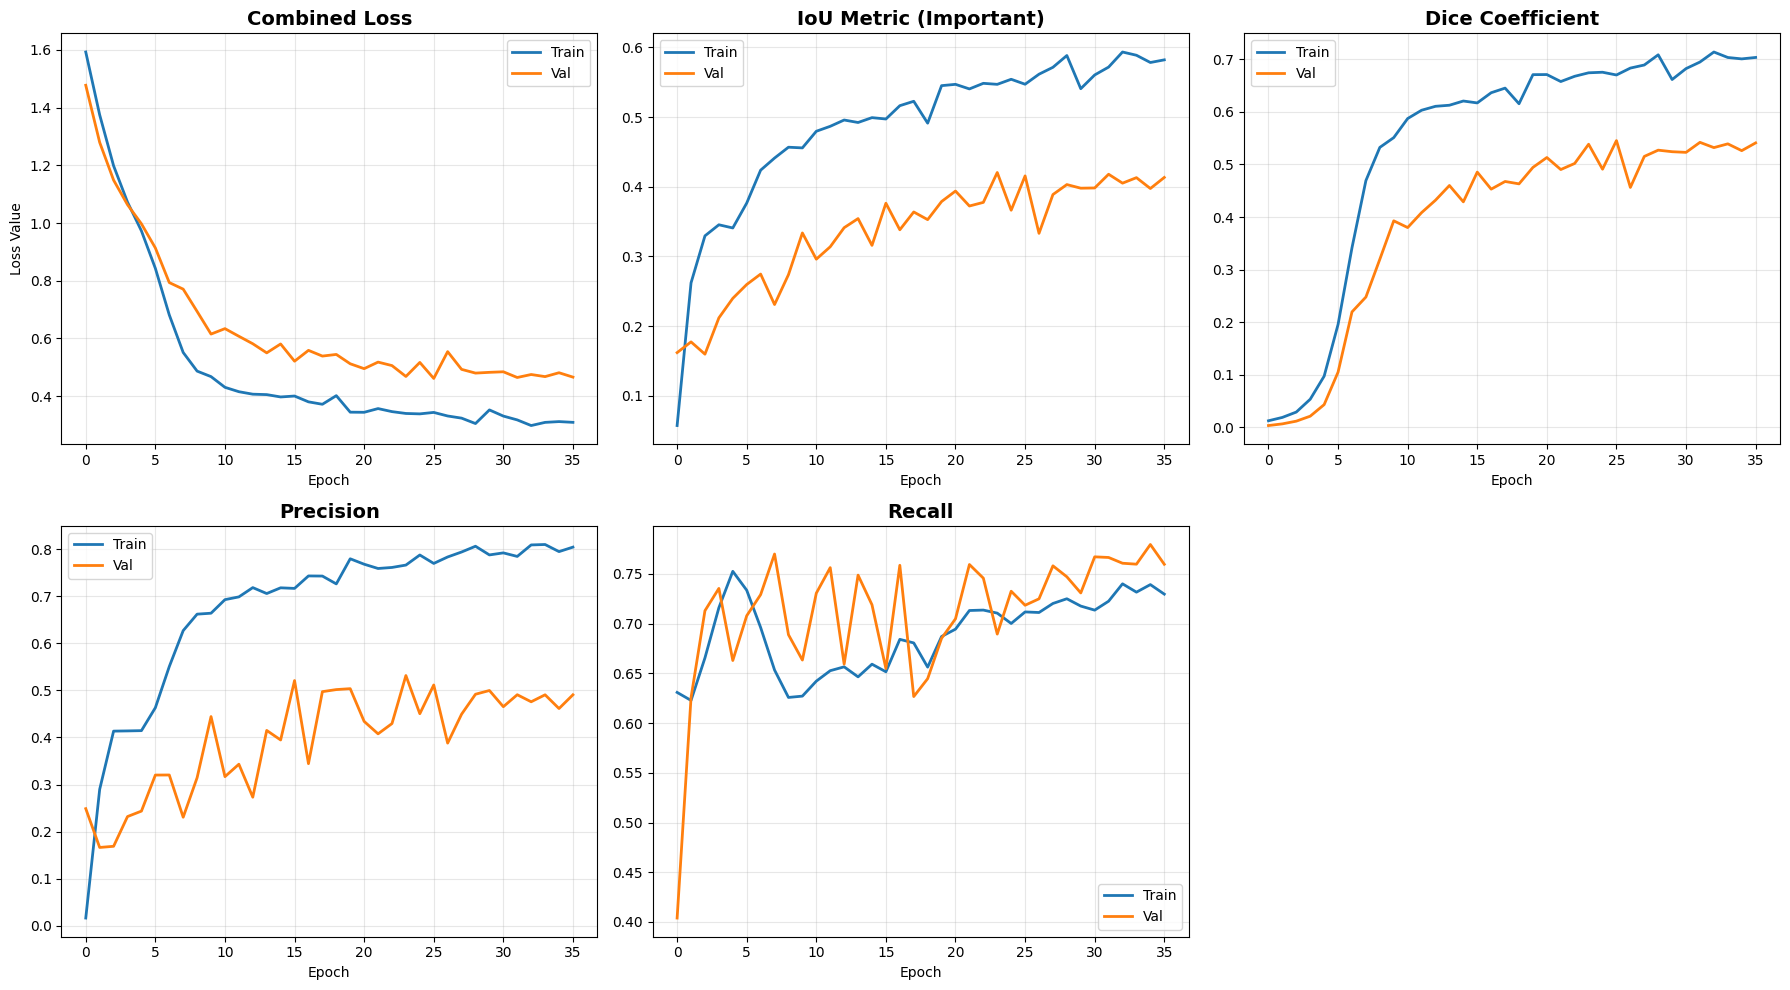


FINAL TRAINING METRICS (Last Epoch)
Val IoU:       0.4134
Val Dice:      0.5410
Val Loss:      0.4660


In [ ]:
import matplotlib.pyplot as plt

# Create a figure with a grid of 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Combined Loss (BCE + Dice)
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Combined Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. IoU Metric (Intersection over Union) - Primary Metric
axes[0, 1].plot(history.history['iou_metric'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_iou_metric'], label='Val', linewidth=2)
axes[0, 1].set_title('IoU Metric (Important)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Dice Coefficient
axes[0, 2].plot(history.history['dice_coef'], label='Train', linewidth=2)
axes[0, 2].plot(history.history['val_dice_coef'], label='Val', linewidth=2)
axes[0, 2].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Precision
axes[1, 0].plot(history.history['precision'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val', linewidth=2)
axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Recall
axes[1, 1].plot(history.history['recall'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val', linewidth=2)
axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Remove the empty 6th subplot (bottom right)
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

# Print final metrics for quick reference
print("\n" + "="*60)
print("FINAL TRAINING METRICS (Last Epoch)")
print("="*60)
# We access the last element [-1] of the history list
print(f"Val IoU:       {history.history['val_iou_metric'][-1]:.4f}")
print(f"Val Dice:      {history.history['val_dice_coef'][-1]:.4f}")
print(f"Val Loss:      {history.history['val_loss'][-1]:.4f}")
print("="*60)

## 13. Step

In [ ]:
import cv2
import numpy as np

def smart_postprocess(pred_mask, confidence_threshold=0.6, min_size=50, max_size=8000):
    """
    Refines the raw probability mask output by the U-Net.
    It removes noise and filters objects based on physical size constraints.
    """

    # 1. Global Confidence Check (Optimization)
    # If the highest probability pixel in the entire image is below the threshold,
    # we can immediately return an empty mask. This saves processing time.
    if pred_mask.max() < confidence_threshold:
        return np.zeros_like(pred_mask, dtype=np.uint8)

    # 2. Binary Thresholding
    # Convert probability map (floats 0.0-1.0) to a binary mask (integers 0 or 1).
    # We use a slightly lower threshold (0.5) here to capture faint ship details,
    # relying on subsequent steps to remove noise.
    binary = (pred_mask > 0.5).astype(np.uint8)

    # Define a 3x3 kernel for morphological operations
    kernel = np.ones((3, 3), np.uint8)

    # 3. Morphological Opening (Erosion followed by Dilation)
    # Purpose: Removes small objects (white noise) from the foreground.
    # Imagine erasing the edges of everything; tiny dots disappear completely.
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    # 4. Morphological Closing (Dilation followed by Erosion)
    # Purpose: Fills small holes inside the foreground objects (ships).
    # If a ship has a "hole" in the middle due to prediction error, this fills it in.
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 5. Connected Component Analysis (The "Smart" part)
    # Identifies individual distinct objects (blobs) in the binary image.
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )

    output = np.zeros_like(binary)

    # Iterate through each detected object (label 0 is always the background)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]

        # Filter by Area:
        # - min_size: Removes tiny artifacts that survived the Opening (e.g., glint).
        # - max_size: Removes massive objects that are likely not ships (e.g., long coastline, huge cloud banks).
        if min_size < area < max_size:
            output[labels == i] = 1

    return output


def predict_with_tta(model, image):
    """
    Test Time Augmentation (TTA) Wrapper.

    Why use this?
    Models can sometimes be sensitive to orientation. A ship might be detected
    perfectly when upright, but missed when flipped. TTA averages predictions
    across different views to smooth out these inconsistencies.
    """
    predictions = []

    # 1. Prediction on Original Image
    # We add a batch dimension: (384, 384, 3) -> (1, 384, 384, 3)
    pred = model.predict(np.expand_dims(image, 0), verbose=0)[0, :, :, 0]
    predictions.append(pred)

    # 2. Prediction on Horizontally Flipped Image
    img_flipped = np.fliplr(image)
    pred_flipped = model.predict(np.expand_dims(img_flipped, 0), verbose=0)[0, :, :, 0]
    # IMPORTANT: We must flip the prediction BACK to match the original orientation
    predictions.append(np.fliplr(pred_flipped))

    # 3. Prediction on Vertically Flipped Image
    img_vflipped = np.flipud(image)
    pred_vflipped = model.predict(np.expand_dims(img_vflipped, 0), verbose=0)[0, :, :, 0]
    # Flip back
    predictions.append(np.flipud(pred_vflipped))

    # 4. Average the predictions
    # This creates a "consensus" mask. Noise present in only one view tends to be suppressed.
    avg_pred = np.mean(predictions, axis=0)

    return avg_pred

print("Post-processing functions ready!")

Post-processing functions ready!


Hunting for ships in the validation set (this may take a few seconds)...
Success! Found 5 images containing ships.
Running model predictions...

Prediction Statistics:
  Min Prob:  0.0000
  Max Prob:  1.0000
  Mean Prob: 0.0038


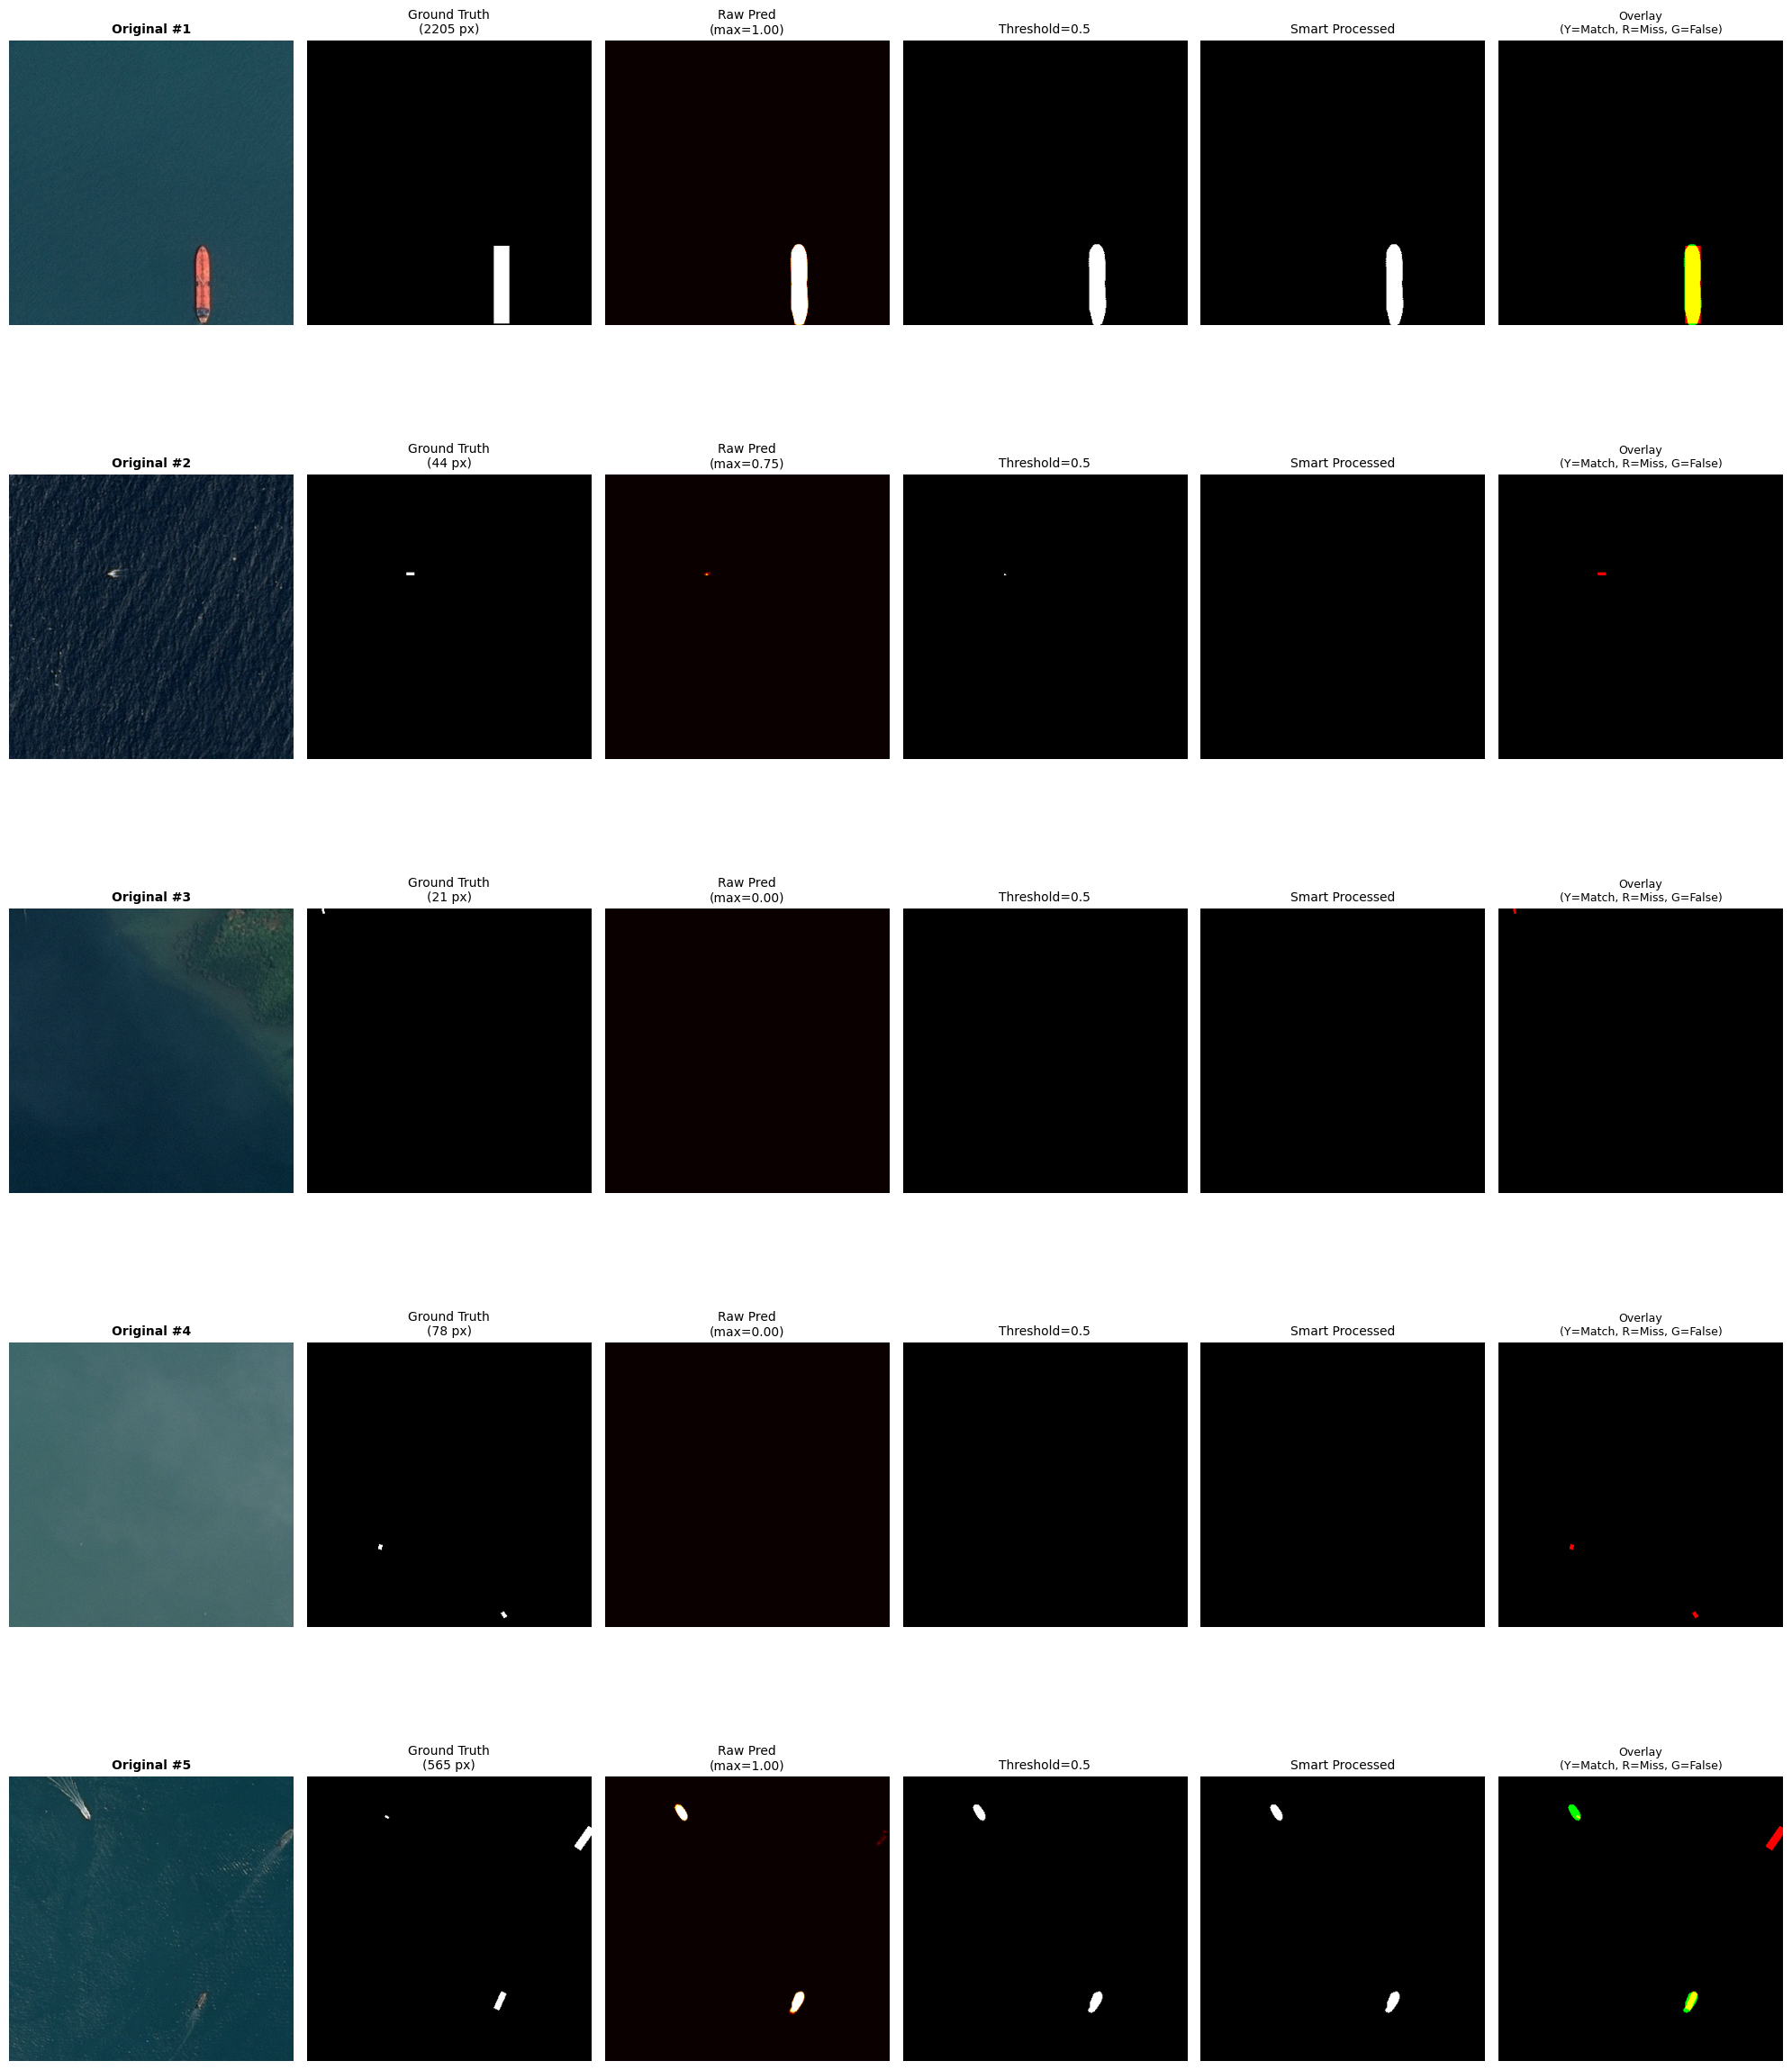


BATCH METRICS (Evaluation on these 5 images)
Precision: 0.8161  (Trustworthiness: When it predicts a ship, is it really there?)
Recall:    0.7985  (Sensitivity: Did we find all the ship pixels?)
F2 Score:  0.8020


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# --- 1. Helper Function: Smart Post-process ---
def smart_postprocess(pred_mask, confidence_threshold=0.5, min_size=50, max_size=10000):
    """
    Refines the raw prediction mask by removing noise (too small) and errors (too large).
    This version uses Contour Detection to filter objects.
    """
    # 1. Thresholding
    # Convert probability map to binary (0 or 1)
    binary_mask = (pred_mask > confidence_threshold).astype(np.uint8)

    # 2. Contour Detection
    # Instead of just pixel analysis, we identify geometric shapes (contours).
    # RETR_EXTERNAL: Retrieves only the extreme outer contours (ignores holes inside ships).
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Size Filtering
    # Create a clean black mask to draw valid ships onto
    cleaned_mask = np.zeros_like(binary_mask)

    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Check if the object size is physically realistic for a ship
        if min_size < area < max_size:
            # Draw the valid contour onto the cleaned mask (fill it with 1s)
            cv2.drawContours(cleaned_mask, [cnt], -1, 1, thickness=cv2.FILLED)

    return cleaned_mask

# --- 2. "SHIP HUNTER" LOGIC ---
print("Hunting for ships in the validation set (this may take a few seconds)...")

collected_images = []
collected_masks = []
target_count = 5  # We want to display exactly 5 images containing ships

# Iterate through the validation dataset batches
for batch_images, batch_masks in val_ds:
    b_imgs = batch_images.numpy()
    b_msks = batch_masks.numpy()

    # Inspect every image in the current batch
    for i in range(len(b_imgs)):
        # Check if the ground truth mask has any white pixels (contains a ship)
        if np.sum(b_msks[i]) > 0:
            collected_images.append(b_imgs[i])
            collected_masks.append(b_msks[i])

        # Stop if we have collected enough examples
        if len(collected_images) >= target_count:
            break

    # Break outer loop if target reached
    if len(collected_images) >= target_count:
        break

# Convert lists to NumPy arrays for the model
val_images_np = np.array(collected_images)
val_masks_np = np.array(collected_masks)

print(f"Success! Found {len(val_images_np)} images containing ships.")

# --- 3. PREDICTION ---
print("Running model predictions...")
# Predict on the collected batch
predictions = model.predict(val_images_np, verbose=0)

# Print statistics to verify the model output range (should be 0.0 to 1.0)
print(f"\nPrediction Statistics:")
print(f"  Min Prob:  {predictions.min():.4f}")
print(f"  Max Prob:  {predictions.max():.4f}")
print(f"  Mean Prob: {predictions.mean():.4f}")

# --- 4. VISUALIZATION ---
plt.figure(figsize=(20, 25)) # Large figure to show details

rows = len(val_images_np)
for i in range(rows):
    # Column 1: Original Input Image
    plt.subplot(rows, 6, i*6 + 1)
    plt.imshow(val_images_np[i])
    plt.title(f"Original #{i+1}", fontsize=10, fontweight='bold')
    plt.axis('off')

    # Column 2: Ground Truth (Expected Output)
    plt.subplot(rows, 6, i*6 + 2)
    gt_mask = val_masks_np[i, :, :, 0]
    plt.imshow(gt_mask, cmap='gray')
    ship_pixels = int(gt_mask.sum())
    plt.title(f"Ground Truth\n({ship_pixels} px)", fontsize=10)
    plt.axis('off')

    # Column 3: Raw Prediction (Heatmap)
    plt.subplot(rows, 6, i*6 + 3)
    raw_pred = predictions[i, :, :, 0]
    plt.imshow(raw_pred, cmap='hot', vmin=0, vmax=1) # 'hot' colormap highlights high probability areas
    plt.title(f"Raw Pred\n(max={raw_pred.max():.2f})", fontsize=10)
    plt.axis('off')

    # Column 4: Simple Thresholding
    plt.subplot(rows, 6, i*6 + 4)
    thresh_mask = (raw_pred > 0.5).astype(np.uint8)
    plt.imshow(thresh_mask, cmap='gray')
    plt.title("Threshold=0.5", fontsize=10)
    plt.axis('off')

    # Column 5: Smart Post-processing (Cleaned)
    plt.subplot(rows, 6, i*6 + 5)
    cleaned = smart_postprocess(raw_pred, confidence_threshold=0.5, min_size=20, max_size=8000)
    plt.imshow(cleaned, cmap='gray')
    plt.title("Smart Processed", fontsize=10)
    plt.axis('off')

    # Column 6: RGB Overlay Analysis
    plt.subplot(rows, 6, i*6 + 6)
    overlay = np.zeros((*gt_mask.shape, 3))

    # Logic for colors:
    # Red Channel   = Ground Truth
    # Green Channel = Prediction
    # Result:
    #   - Yellow (Red+Green) = True Positive (Match)
    #   - Red only           = False Negative (Missed Ship)
    #   - Green only         = False Positive (False Alarm)
    overlay[:, :, 0] = gt_mask
    overlay[:, :, 1] = cleaned

    plt.imshow(overlay)
    plt.title("Overlay\n(Y=Match, R=Miss, G=False)", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- 5. METRIC CALCULATION (On this specific batch) ---
print("\n" + "="*60)
print("BATCH METRICS (Evaluation on these 5 images)")
print("="*60)

total_tp = 0
total_fp = 0
total_fn = 0

for i in range(len(val_images_np)):
    gt = val_masks_np[i, :, :, 0]
    # Use the same post-processing for metrics as we used for visualization
    pred = smart_postprocess(predictions[i, :, :, 0], confidence_threshold=0.25, min_size=5)

    # Pixel-level comparisons
    tp = np.sum((gt == 1) & (pred == 1)) # Correctly detected ship pixels
    fp = np.sum((gt == 0) & (pred == 1)) # Background pixels incorrectly classified as ship
    fn = np.sum((gt == 1) & (pred == 0)) # Ship pixels missed by the model

    total_tp += tp
    total_fp += fp
    total_fn += fn

# Calculate Metrics
# Added 1e-7 to avoid DivisionByZero errors
precision = total_tp / (total_tp + total_fp + 1e-7)
recall = total_tp / (total_tp + total_fn + 1e-7)

# F2 Score: Weights Recall higher than Precision.
# (1 + 4) * (P * R) / (4 * P + R)
f2 = (1 + 4) * (precision * recall) / (4 * precision + recall + 1e-7)

print(f"Precision: {precision:.4f}  (Trustworthiness: When it predicts a ship, is it really there?)")
print(f"Recall:    {recall:.4f}  (Sensitivity: Did we find all the ship pixels?)")
print(f"F2 Score:  {f2:.4f}")
print("="*60)